# EDA for fake news data

In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

## urls

In [2]:
df = pd.read_csv('fake_news_training.csv')
df

,baseurl,content,label
0,twitter.com,\njavascript is not available.\n\nwe’ve detect...,real
1,whitehouse.gov,remarks by the president at campaign event -- ...,real
2,web.archive.org,the committee on energy and commerce\nbarton: ...,real
...,...,...,...
658,politico.com,full text: jeff flake on trump speech transcri...,fake
659,pol.moveon.org,moveon.org political action: 10 things to know...,real
660,uspostman.com,"uspostman.com is for sale\nyes, you can transf...",fake


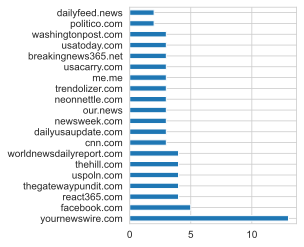

In [3]:
(df
 .query('label == "fake"')
 ['baseurl']
 .value_counts()
 .iloc[:20]
 .plot(kind='barh', figsize=(3, 4))
);

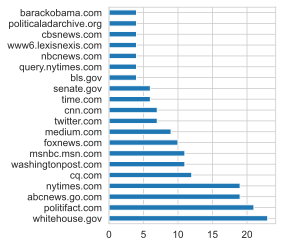

In [4]:
(df
 .query('label == "real"')
 ['baseurl']
 .value_counts()
 .iloc[:20]
 .plot(kind='barh', figsize=(3, 4))
);

In [5]:
len(df['baseurl'].unique())

378

In [6]:
(df
 .assign(is_real=lambda df: df['label'] == 'real')
 .groupby('baseurl')
 ['is_real']
 .mean()
 .sort_values(ascending=False)
)

baseurl
pollingreport.com     1.0
flake.senate.gov      1.0
foreignaffairs.org    1.0
                     ... 
newscats.org          0.0
newsdaily12.com       0.0
zerohedge.com         0.0
Name: is_real, Length: 378, dtype: float64

### tokenizing

In [7]:
import nltk
from nltk.stem.porter import PorterStemmer

stop_words = set(nltk.corpus.stopwords.words('english'))
porter_stemmer = PorterStemmer()

def stemming_tokenizer(document):
    return [porter_stemmer.stem(word)
            for word in nltk.word_tokenize(document)
            if word not in stop_words]
    return words

In [8]:
%%time

df = df.assign(tokens=df['content'].apply(stemming_tokenizer))
df

CPU times: user 12.7 s, sys: 34.4 ms, total: 12.7 s
Wall time: 12.8 s


,baseurl,content,label,tokens
0,twitter.com,\njavascript is not available.\n\nwe’ve detect...,real,"[javascript, avail, ., ’, detect, javascript, ..."
1,whitehouse.gov,remarks by the president at campaign event -- ...,real,"[remark, presid, campaign, event, --, colorado..."
2,web.archive.org,the committee on energy and commerce\nbarton: ...,real,"[committe, energi, commerc, barton, :, medicar..."
...,...,...,...,...
658,politico.com,full text: jeff flake on trump speech transcri...,fake,"[full, text, :, jeff, flake, trump, speech, tr..."
659,pol.moveon.org,moveon.org political action: 10 things to know...,real,"[moveon.org, polit, action, :, 10, thing, know..."
660,uspostman.com,"uspostman.com is for sale\nyes, you can transf...",fake,"[uspostman.com, sale, ye, ,, transfer, domain,..."


In [9]:
tokens_df = df.explode('tokens')
tokens_df

,baseurl,content,label,tokens
0,twitter.com,\njavascript is not available.\n\nwe’ve detect...,real,javascript
0,twitter.com,\njavascript is not available.\n\nwe’ve detect...,real,avail
0,twitter.com,\njavascript is not available.\n\nwe’ve detect...,real,.
...,...,...,...,...
660,uspostman.com,"uspostman.com is for sale\nyes, you can transf...",fake,pleas
660,uspostman.com,"uspostman.com is for sale\nyes, you can transf...",fake,click
660,uspostman.com,"uspostman.com is for sale\nyes, you can transf...",fake,.


In [10]:
(tokens_df
 .query('label == "real"')
 ['tokens']
 .value_counts()
)

,              48472
.              44663
:              10251
               ...  
transatlant        1
highrisk           1
1304               1
Name: tokens, Length: 24296, dtype: int64

In [11]:
(tokens_df
 .query('label == "fake"')
 ['tokens']
 .value_counts()
)

,          5045
.          3967
’          1727
           ... 
dimens        1
edg           1
grandma       1
Name: tokens, Length: 9597, dtype: int64

not very helpful because of punctuation

## tf-idf and PCA

## looking for words that might be good features

what about restricting tokens to nouns and verbs?

In [17]:
# needed to run:
# nltk.download('averaged_perceptron_tagger')
# to get model.

# pos stands for parts-of-speech
nltk.pos_tag(tokens_df['tokens'][:10])

[('javascript', 'NN'),
 ('avail', 'NN'),
 ('.', '.'),
 ('’', 'CC'),
 ('detect', 'JJ'),
 ('javascript', 'NN'),
 ('disabl', 'NN'),
 ('browser', 'NN'),
 ('.', '.'),
 ('pleas', 'NNS')]

`'NN'` denotes a noun.

In [24]:
%%time

tag_df = tokens_df.assign(
    tag=[pos for _, pos in nltk.pos_tag(tokens_df['tokens'])])
         
tag_df

CPU times: user 21.8 s, sys: 90.6 ms, total: 21.9 s
Wall time: 22 s


,baseurl,content,label,tokens,tag
0,twitter.com,\njavascript is not available.\n\nwe’ve detect...,real,javascript,NN
0,twitter.com,\njavascript is not available.\n\nwe’ve detect...,real,avail,NN
0,twitter.com,\njavascript is not available.\n\nwe’ve detect...,real,.,.
...,...,...,...,...,...
660,uspostman.com,"uspostman.com is for sale\nyes, you can transf...",fake,pleas,JJ
660,uspostman.com,"uspostman.com is for sale\nyes, you can transf...",fake,click,NN
660,uspostman.com,"uspostman.com is for sale\nyes, you can transf...",fake,.,.


In [49]:
import re

# nltk.help.upenn_tagset()
# gets adjectives (J), nouns (N), adverbs (R), verbs (V)
tag_re = re.compile(r'(J|N|R|V)\w+')

In [52]:
(tag_df[tag_df['tag'].str.match(tag_re)]
 .query('label == "real"')
 ['tokens']
 .value_counts()
 .to_frame()
)

,tokens
’,6911
go,4385
n't,3189
...,...
3/19-22/16,1
news/nbc,1
beinvestig,1


In [51]:
df_interact(tag_df[tag_df['tag'].str.match(tag_re)]
 .query('label == "real"')
 ['tokens']
 .value_counts()
 .to_frame()
)

interactive(children=(IntSlider(value=0, description='row', max=20362, step=7), Output()), _dom_classes=('widg…

(20362 rows, 1 columns) total


In [53]:
df_interact(tag_df[tag_df['tag'].str.match(tag_re)]
 .query('label == "fake"')
 ['tokens']
 .value_counts()
 .to_frame()
)

interactive(children=(IntSlider(value=0, description='row', max=8976, step=7), Output()), _dom_classes=('widge…

(8976 rows, 1 columns) total
